# Clustering com Dados do Cartola FC

## 1.0 Dataset

Foram utilizados dados do Cartola FC obtido através do seguinte [respositório](https://github.com/henriquepgomide/caRtola) do GitHub. O CSV utilizado foi o "dados_agregados_limpos.csv", o qual é a junção dos dados dos anos de 2014 a 2018, além de serem dados já tratados sem a presença de NaN.

Cada linha representa...

Colunas relevantes:
- Rodada: número da rodada do Brasileirão
- ClubeID: clube do jogador
- AtletaID: id do jogador
- Posicao: posição do jogador
- Pontos: pontuação do jogador
- PontosMedia: média da pontuação do jogador
- FS: faltas sofridas
- PE: passes errados
- A: assistências
- FT: finalizações na trave
- FD: finalizações defendidas
- FF: finalizações para fora
- G: gols
- I: impedimentos
- FC: faltas cometidas
- CA: cartões amarelo
- CV: cartões vermelho
- SG: jogos sem sofrer gols
- GS: gols sofridos
- RB: roubadas de bola
- DD: defesas difíceis
- DP: defesas de pênalti

Primeiro, será clusterizado os jogadores separadamente, ou seja, o agrupamento será feito separadamente para cada posição (goleiro, zagueiro, atacante, lateral e meia).

Após essa primeira etapa, será feito...

In [114]:
import pandas as pd
import numpy as np

dados_agregados = pd.read_csv('dados_agregados_limpos.csv')
dados_agregados.shape

(17567, 77)

## 2.0 Explorando os dados

### 2.1 Tipos de posição e a quantidade:

In [4]:
dados_agregados.Posicao.value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

### 2.2 Descrição das colunas

In [17]:
colunas = ['Pontos','PontosMedia','FS','PE','A','FT','FF','FC',
           'FD','G','I','RB','CA','CV','SG','DD','DP','GS']

dados_agregados[colunas].describe()

,Pontos,PontosMedia,FS,PE,A,FT,FF,FC,FD,G,I,RB,CA,CV,SG,DD,DP,GS
count,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000,17567.000000
mean,2.946798,2.960628,1.111914,2.315763,0.064325,0.018102,0.347356,1.159845,0.241305,0.090169,0.136847,1.026015,0.169693,0.008140,0.124039,0.115671,0.002505,0.090169
std,4.344379,2.050958,1.304447,2.042131,0.262381,0.135862,0.644317,1.260528,0.538621,0.315378,0.440791,1.265575,0.375980,0.090489,0.329636,0.552542,0.051112,0.435866
min,-10.500000,-8.400000,-3.000000,-6.000000,-1.000000,0.000000,-1.000000,-2.000000,-2.000000,0.000000,-1.000000,-4.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.680000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.880000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.200000,4.090000,2.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.000000,21.830000,12.000000,14.000000,4.000000,2.000000,7.000000,10.000000,6.000000,3.000000,7.000000,9.000000,1.000000,1.000000,1.000000,7.000000,2.000000,6.000000


In [42]:
teste = dados_agregados[colunas].describe()
teste.loc['mean','Pontos']

2.946797973472989

### 2.3 Tratar dados duplicados

A problemática é a repetição do valor "AtletaID" nas linhas do dataset, visto que um atleta pode ter participado de várias partidas. Para resolver esse problema, será calculada a média das colunas a serem utilizadas.

In [0]:
dados = dados_agregados.copy()
# filtrando apenas as colunas que serão usadas
dados = dados[['ClubeID','AtletaID','Posicao','Pontos','FS','PE','A','FT','FF','FC',
           'FD','G','I','RB','CA','CV','SG','DD','DP','GS']]

Nas análises abaixo estamos:
- conferindo se AtletaID só tem um tipo de posição;
- se o AtletaID participou de mais de um ClubeID.

In [148]:
display(dados.groupby(['AtletaID']).Posicao.unique().reset_index().head(10))

display(dados.groupby(['AtletaID']).ClubeID.unique().reset_index().head(10))

,AtletaID,Posicao
0,36540,[zag]
1,36612,[lat]
2,37604,[zag]
3,37607,"[lat, mei]"
4,37608,[mei]
5,37623,[zag]
6,37644,[zag]
7,37646,[zag]
8,37652,[mei]
9,37653,[ata]


,AtletaID,ClubeID
0,36540,"[Internacional, Flamengo]"
1,36612,"[Grêmio, Palmeiras]"
2,37604,[Atlético-PR]
3,37607,"[São Paulo, Palmeiras]"
4,37608,[Grêmio]
5,37623,[Vasco]
6,37644,[Ponte Preta]
7,37646,[Avaí]
8,37652,"[Botafogo, Figueirense, Atlético-PR]"
9,37653,"[Internacional, Santos]"


Como alguns AtletaID estão relacionados com mais de uma tipo de posição e a mais de um Clube, iremos guardar essa informações em uma lista na coluna específica.

In [147]:
# Agrupar por Clube também?
df_mean = dados.groupby(['AtletaID','Posicao']).mean().reset_index()
df_mean.head()

,AtletaID,Posicao,Pontos,FS,PE,A,FT,FF,FC,FD,G,I,RB,CA,CV,SG,DD,DP,GS
0,36540,zag,4.095349,0.627907,1.418605,0.069767,0.023256,0.441860,0.860465,0.186047,0.000000,0.000000,1.348837,0.279070,0.000000,0.395349,0.0,0.0,0.0
1,36612,lat,2.895588,1.088235,1.705882,0.147059,0.000000,0.191176,0.926471,0.073529,0.014706,0.102941,1.441176,0.176471,0.000000,0.044118,0.0,0.0,0.0
2,37604,zag,1.711111,0.611111,2.277778,0.000000,0.055556,0.000000,0.777778,0.111111,0.000000,0.000000,0.722222,0.222222,0.000000,0.277778,0.0,0.0,0.0
3,37607,lat,2.642424,0.424242,3.090909,0.242424,0.000000,0.575758,0.969697,0.454545,0.060606,0.393939,0.606061,0.151515,0.060606,0.212121,0.0,0.0,0.0
4,37607,mei,2.300000,0.785714,2.857143,0.142857,0.000000,0.857143,0.785714,0.214286,0.000000,0.214286,1.357143,0.285714,0.000000,0.000000,0.0,0.0,0.0


### 2.4 Separação das posições dos jogadores

Abaixo é feita a filtragem do dataframe de acordo com a posição dos jogadores.

In [0]:
dados_meia = df_mean[df_mean['Posicao']=='mei']
dados_meia = dados_meia[['AtletaID','Pontos','FS','PE','A','G','I','RB','FC','CA','CV']]

dados_atacante = df_mean[df_mean['Posicao']=='ata']
dados_atacante = dados_atacante[['AtletaID','Pontos','FS','PE','A','FT','FF','G','I','RB','CA','CV']]

dados_lateral = df_mean[df_mean['Posicao']=='lat']
dados_lateral = dados_lateral[['AtletaID','Pontos','FS','PE','A','G','I','RB','FC','CA','CV']]

dados_zaga = df_mean[df_mean['Posicao']=='zag']
dados_zaga = dados_zaga[['AtletaID','Pontos','PE','G','RB','FC','CA','CV']]

dados_gol = df_mean[df_mean['Posicao']=='gol']
# dados_gol = dados_gol[['AtletaID','Pontos','FD','SG','DD','DP','GS']]

## 3.0 Clusterização das posições

Descrever sobre o método utilizado, número de grupos...

In [0]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

kmeans_model = KMeans(n_clusters=3, random_state=1)

### 3.1 Atacante

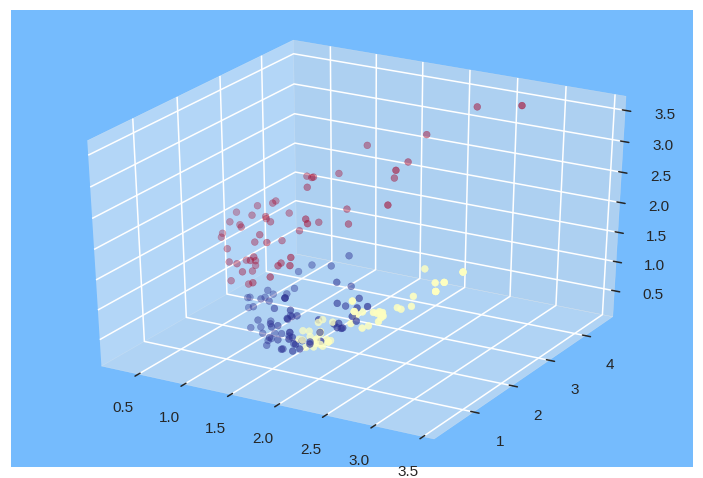

In [236]:
distancias_ata = kmeans_model.fit_transform(dados_atacante.iloc[:,2:])

labels = kmeans_model.labels_

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_ata[:,0]
ys = distancias_ata[:,1]
zs = distancias_ata[:,2]
ax.scatter(xs, ys, zs, c=labels, cmap="RdYlBu")

plt.show()

### 3.2 Zagueiro

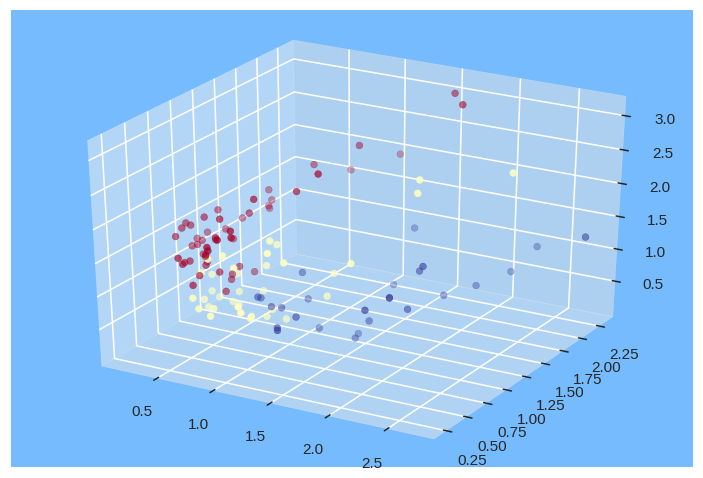

In [237]:
distancias_zag = kmeans_model.fit_transform(dados_zaga.iloc[:,2:])

labels = kmeans_model.labels_

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_zag[:,0]
ys = distancias_zag[:,1]
zs = distancias_zag[:,2]
ax.scatter(xs, ys, zs, c=labels, cmap="RdYlBu")

plt.show()

### 3.3 Lateral

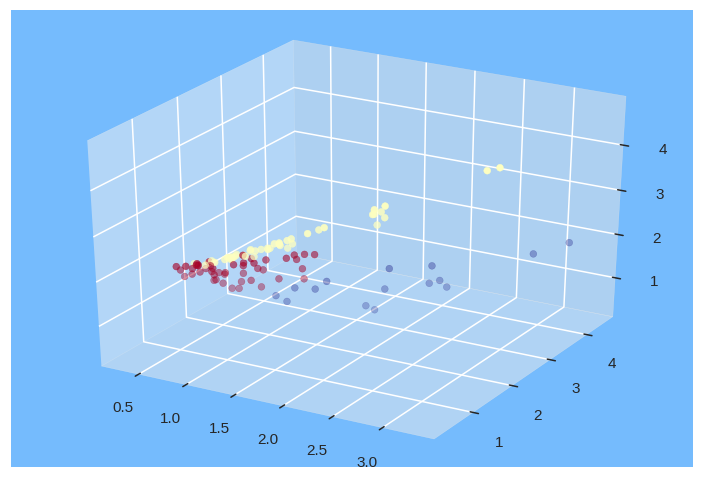

In [238]:
distancias_lateral = kmeans_model.fit_transform(dados_lateral.iloc[:,2:])

labels = kmeans_model.labels_

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_lateral[:,0]
ys = distancias_lateral[:,1]
zs = distancias_lateral[:,2]
ax.scatter(xs, ys, zs, c=labels, cmap="RdYlBu")

plt.show()

### 3.4 Meia

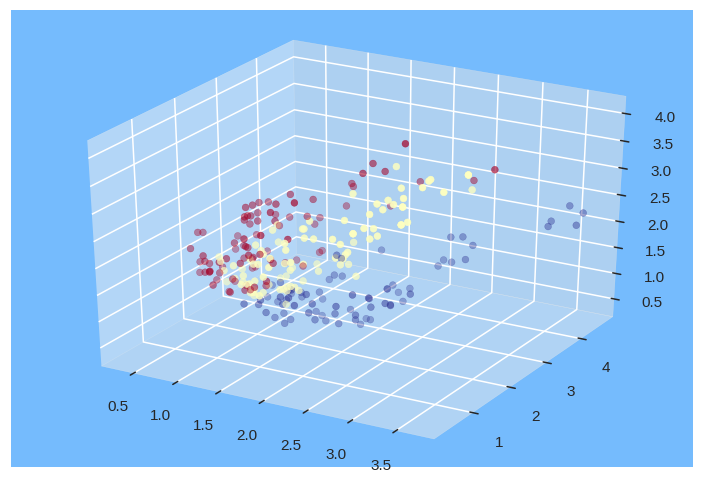

In [239]:
distancias_meia = kmeans_model.fit_transform(dados_meia.iloc[:,2:])

labels = kmeans_model.labels_

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_meia[:,0]
ys = distancias_meia[:,1]
zs = distancias_meia[:,2]
ax.scatter(xs, ys, zs, c=labels, cmap="RdYlBu")

plt.show()

### 3.5 Goleiro

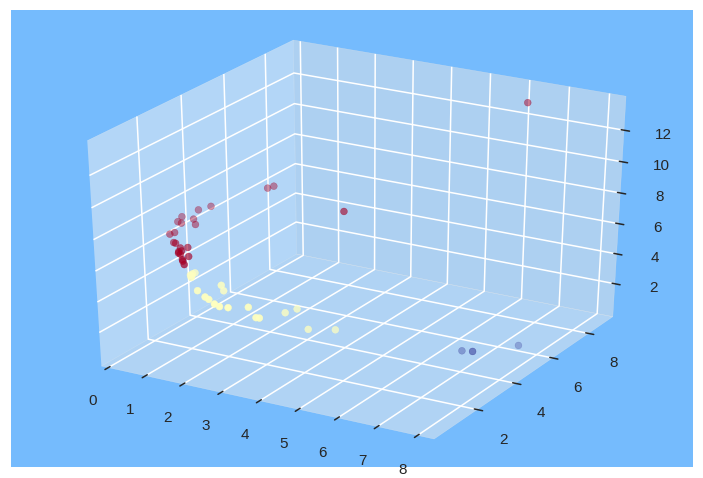

In [242]:
distancias_gol = kmeans_model.fit_transform(dados_gol.iloc[:,2:])

labels = kmeans_model.labels_

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('xkcd:sky blue')

xs = distancias_gol[:,0]
ys = distancias_gol[:,1]
zs = distancias_gol[:,2]
ax.scatter(xs, ys, zs, c=labels, cmap="RdYlBu")

plt.show()